<a href="https://colab.research.google.com/github/pavi-ninjaac/NuralNetwork_scratch/blob/main/CNN/ConvolutionalLayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# conolutional layer
import numpy as np

In [2]:
class con2D:
  def __init__(self, filter , kernal_size, img_channel,strides = (1,1)):
    self.filter = None
    self.bias = None
    self.input = None
    """Convolute the image with the filter and strids"""
    
    
    f_channel = img_channel               #filter channel must match with the image channel
    self.no_filters = filter                   # number of filters
    f_dim , _ = kernal_size
    self.f_dim =  f_dim              # get the filter size
    self.strides , _ = strides
    f_size = (self.no_filters , f_channel , f_dim , f_dim) # get the strides dimentions

    #initialize the filter
    """ Initalize the filter with the noraml distribution with the standard deviation inversely proportional the square root of the number of units"""
    sdv = 1.0 / np.sqrt(np.prod(f_size))
    self.filter = np.random.normal(loc = 0, scale = sdv, size = f_size)
    #self.filter = np.array([[[1,0,1] , [2,1,1] , [0,1,2]]])
    self.bias = np.zeros((self.no_filters , 1)) # each for the one filters    

  
  #forward propogaton
  def forward_propogation(self, image):
    self.input = image
    #print(image.shape)
    (img_channel , input_dim , _ ) = image.shape #input dimensions channel first dimention 
    
    #calculate the output dimension, so according to that i can create the empty array to store value
    out_dim = int(((input_dim - self.f_dim) / self.strides) + 1)
    
    #create the empty array with output dimetions
    self.output = np.zeros((1 , out_dim, out_dim )) #syntax np.zeros(channel , row , col)
    for curr_filter in range(self.no_filters): # for loop over the number of filters
      curr_y = out_y =0
      
      #move vertically over the image
      while (curr_y + self.f_dim) <= input_dim:
        curr_x = out_x = 0
        #move horizondally
        while (curr_x + self.f_dim) <= input_dim:
          
          """perform convolution operation on the image"""
          self.output[curr_filter , curr_y , curr_x] = np.sum(self.filter[curr_filter] * image[: , curr_y : curr_y + self.f_dim , curr_x : curr_x + self.f_dim]) #+ self.bias[curr_filter]

          curr_x += self.strides
          out_x +=1
        curr_y += self.strides
        out_y += 1
    #print(self.output)
    return self.output

  def back_propogation(self , error_input , learning_rate):
      """update the filter """ # gonna use the self.no_filters and self.f_dim
      image_channel , img_dim , _ = self.input.shape

      #initialize the derivations by creating zero array
      dout = np.zeros(self.input.shape)
      d_filter = np.zeros(self.filter.shape)
      d_bias = np.zeros(self.bias.shape)
      for curr_filter in range(self.no_filters): # for loop over the number of filters
        curr_y = out_y =0
      
        #move vertically over the image
        while (curr_y + self.f_dim) <= img_dim:
          curr_x = out_x = 0
          #move horizondally
          while (curr_x + self.f_dim) <= img_dim:
          
            """loss gradiant on filters"""
            #update the filter
            #print('filter' , self.filter)
            #print('zero filter' , d_filter)
            d_filter[curr_filter] +=  error_input[curr_filter , out_y , out_x] * self.input[: , curr_y : curr_y + self.f_dim , curr_x : curr_x + self.f_dim]

            #gradiant of the input 
            dout[: , curr_y : curr_y + self.f_dim , curr_x : curr_x + self.f_dim] += error_input[curr_filter , out_y , out_x] * self.filter[curr_filter]

            
            curr_x += self.strides
            out_x +=1
          curr_y += self.strides
          out_y += 1
        d_bias[curr_filter] = np.sum(error_input[curr_filter])
    #update the weights
        self.filter = d_filter
        self.bias = d_bias
      #print(dout)
      return dout


In [3]:
class MaxPooling2D(con2D):
  def __init__(self , pool_size = 1, strides=1):
    self.pool_size = pool_size #getting the kernal size for pooling the layer out
    self.strides = strides
    self.image = None
    
  def forward_propogation(self , image):

    """ downsample of the image using the kernal size and strides"""
    self.image = image
    img_channel , h_prev , w_prev  = image.shape    # shape of the image
    # calculate output dimensions after the maxpooling operation.
    h = int((h_prev - self.pool_size)/self.strides)+1 
    w = int((w_prev - self.pool_size)/self.strides)+1
    
    # create a matrix to hold the values of the maxpooling operation.
    self.output = np.zeros((img_channel, h, w))
    # slide the window over every part of the image using stride s. Take the maximum value at each step.
    for i in range(img_channel):
        curr_y = out_y = 0
        # slide the max pooling window vertically across the image
        while curr_y + self.pool_size <= h_prev:
            curr_x = out_x = 0
            # slide the max pooling window horizontally across the image
            while curr_x + self.pool_size <= w_prev:
                # choose the maximum value within the window at each step and store it to the output matrix
                self.output[i, out_y, out_x] = np.max(image[i, curr_y:curr_y+self.pool_size, curr_x:curr_x+self.pool_size])
                curr_x += self.strides
                out_x += 1
            curr_y += self.strides
            out_y += 1
    #print(self.output)
    return self.output

  def get_max_index(self , arr):
      """return the index of the maximum value in the array"""
      flat_index = np.nanargmax(arr)
      idex = np.unravel_index(flat_index , arr.shape)
      return idex


  def back_propogation(self, output , learning_rate):
      """put the max value in it's old position ,,,fill remaining with zeros"""
      img_channel , img_dim , _  = self.image.shape

      #create an zero value array with the original image size
      dout = np.zeros(self.image.shape)
      # slide the window over every part of the image using stride s. Take the maximum value at each step.
      for cuur_channel in range(img_channel):
        curr_y = out_y = 0
        # slide the max pooling window vertically across the image
        while curr_y + self.pool_size <= img_dim:
            curr_x = out_x = 0
            # slide the max pooling window horizontally across the image
            while curr_x + self.pool_size <= img_dim:
              #obtain the index of the maximum value in that window size
              a,b = self.get_max_index(self.image[cuur_channel , curr_y:curr_y+self.pool_size, curr_x:curr_x+self.pool_size])
              dout[cuur_channel , curr_y+a , curr_x+b] = output[cuur_channel , curr_y , curr_x]

              curr_x += self.strides
              out_x += 1
            curr_y += self.strides
            curr_y += 1
      #print(dout)
      return dout


In [4]:
class Flatten(con2D):
  """ get the strignt single channel fully connet layer """
  def __init__(self):
    self.image = None
    self.flatten_image = None
    
  def forward_propogation(self , image):
    #store the image  size to use in the backpropogation
    self.image = image
    image_channel , input_dim , _ = image.shape
    a = image.flatten()  #flatten the image 
    self.flatten_image = np.array([a]) #make it to 2D
    #print(self.flatten_image)
    #print('flatten image shape for further use',self.flatten_image.shape) 
    return self.flatten_image 

  def back_propogation(self , output , learning_rate):
    output = output.reshape(self.image.shape)
    #print(output)
    return output  # mae it into the original size
    
      

In [5]:
class FClayer(Flatten):
  def __init__(self , input_size , output_size):
    self.input = None
    self.input_size = input_size
    self.output = None
    # initialize the weights using the normal distribution
    self.weights = np.random.rand(self.input_size , output_size) - 0.5
    self.bias =  np.random.rand(1,output_size) - 0.5 
  
  def forward_propogation(self , input):
    self.input = input
    self.output = np.dot(self.input , self.weights) + self.bias
    print(self.output)
    return self.output
  
  def back_propogation(self, output_error , learning_rate):
    #print('coming gradiant' , output_error)
    #print(' weight' , self.weights)
    #print('back input ',self.input)
    #print('bias',self.bias)
    #print('finding the input error')
    #print('the weight transpose' , self.weights.T)
    #print('error',output_error ,'*' ,self.weights.T )
    input_error = np.dot(output_error , self.weights.T)  #dE/dX = W.T * dE / dY
    
    
    #print('input transpose',self.input.T)
    weights_error = np.dot(self.input.T , output_error) #dE/dW = X.T * dE / dY
    bias_error = output_error                           #dE/dB =  dE / dY
    #update the weights and bias
    self.weights -= learning_rate *  weights_error
    self.bias -= learning_rate * bias_error
    #print(input_error)
    return input_error


In [26]:
def softmax_funtion(output):
  """ pass the raw predicted data to the activation function to get the probability"""
  #output = np.array(output , dtype = np.float64)
  #print('softmax function',output.dtype)
  print('coming output',output)
  out = output - (np.max(output))
  print('normalized output' , out)
  out_exp = np.exp(out) # exponent the predicted output
  print('exponential value',out_exp)
  return out_exp / np.sum(out_exp)

def softmax_derivated(loss_derivated_error):
  return loss_derivated_error


In [27]:
def catogarical_cross_entropy(label , prob):
  """ calculate the categorical cross entropy loss"""
  return -np.sum(label * np.log(prob)) #multiply the output with the log of probability

def catogarical_cross_entropy_derivated(label , prob):
  loss_derivated_error =  prob - label 
  print('loss derivated',loss_derivated_error)
  return loss_derivated_error

In [28]:
class softmax(FClayer):
  def __init__(self, actvation = softmax_funtion , activation_derivated = softmax_derivated): #default parameter setting
    self.actvation = actvation #show the activation from the outside class
    self.activation_derivated = activation_derivated

  def forward_propogation(self , input_data):
    self.input = input_data 
    self.output = self.actvation(self.input)
    #print('soft max activation',self.output)
    return self.output

  def back_propogation(self ,  output_error , learning_rate):
    return self.activation_derivated(self.input) * output_error

In [22]:
class Relu(con2D):
  """ pass through the relu activation function"""
  def __init__(self):
    self.output = None

  def forward_propogation(self,input):
    input[input<=0] = 0
    self.output = input
    #print(self.output)
    return self.output
  
  def back_propogation(self,output_error , learning_rate):
    output_error[output_error<=0] = 0
    return output_error


In [29]:
class network:
  def __init__(self):
    self.layers = []

  #add the layer in the model
  def add(self , layer):
    self.layers.append(layer)
  #set the loss function to use it out
  def setloss(self, loss , loss_derivated):
    self.loss = loss
    self.loss_derivated = loss_derivated

  def fit(self , x_train ,  y_train , epoches ,learning_rate):
    sampels = len(x_train)
    #loop over for epoches
    for i in range(epoches):
      err = 0
      for j in range(sampels):
        print('sample' , j)
        output = x_train[j]  #loop our the training image
        for layer in self.layers:
          print(layer)
          output = layer.forward_propogation(output)
          
        print(output.dtype)
        print('output of softmax',output)
          

        #compute the loss
                
        err += self.loss(y_train[j] , output)
        print('loss ',err)
        #backpropogation
        error = self.loss_derivated(y_train[j] , output)
        
        #update the weights
        print('backporopogation stated')
        for layer in reversed(self.layers):
          #print('back',layer)
          error = layer.back_propogation(error , learning_rate)
          
      #displae the error and epoches for the reference
      err/=sampels
      print('epoches..'+str(i)+'/'+str(epoches)+'-------'+'Error',err)
    



# Check it with one image

In [11]:
#import packages
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from keras.preprocessing import image
from keras.datasets import mnist
from keras.utils import np_utils

In [12]:
#load the image dataset
(X_train , y_train ), (X_test , y_test )= mnist.load_data()
print("shape of the X_train ", X_train.shape)
print("shape of the X_train ", y_train.shape)
print("shape of the X_train ", X_test.shape)
print("shape of the X_train ", y_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
shape of the X_train  (60000, 28, 28)
shape of the X_train  (60000,)
shape of the X_train  (10000, 28, 28)
shape of the X_train  (10000,)


# Clean the datsset

In [13]:
X_train =   X_train.reshape(X_train.shape[0] , 1 , 28 , 28)
X_train = X_train.astype('float64')
X_train /= 255.0

#clean the test dataset
X_test =   X_test.reshape(X_test.shape[0] , 1 , 28 , 28)
X_test = X_test.astype('float64')
X_test /= 255.0
#print(X_train[0])
#one hot encode the output
print(y_train[0])
y_train = np_utils.to_categorical(y_train)
print(y_train[0])
y_test = np_utils.to_categorical(y_test)

5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


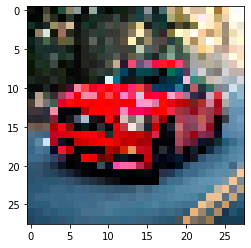

In [14]:
#@title Default title text
car_path = '/content/drive/MyDrive/Colab Notebooks/dataFiles/DNA_Genome_Analysis_covid19/car.png'
car_img = image.load_img(car_path , target_size = (28,28))
car_arr = image.img_to_array(car_img)
plt.imshow(car_img)

In [30]:
#build the model 
model = network()
model.add(con2D(filter = 1 , kernal_size =(3,3) , strides = (1,1) , img_channel =1))
model.add(Relu())
model.add(MaxPooling2D(pool_size = 2))
model.add(Relu())
model.add(Flatten())
model.add(FClayer(625,128))
model.add(FClayer(128,10))
model.add(softmax())

In [31]:
#i = np.array([[[[1,2,1,0,1] , [2,1,1,2,1] , [3,2,1,0,0] , [0,1,2,3,1] , [2,1,1,0,2]]]])
#print(i.shape)
#set the loss to compute the loss
model.setloss(loss = catogarical_cross_entropy , loss_derivated = catogarical_cross_entropy_derivated)
model.fit(X_train ,y_train ,10 , learning_rate = 0.01)

sample 0
[[  1.32269132  -2.00108738   2.11404156   0.99006588  -1.30330136
    5.85594929  -2.65066629  -0.62964678  -1.72598633  -1.53493549
   -6.44816976  -4.67205516   1.50693884   0.304756    -1.9438659
   -3.28841495   4.37446519   4.64881204  -3.93915583   0.2860413
    1.42930196   1.7578297   -2.50531888   0.99602639   1.96165054
   -4.57832852   0.60271465  -1.19500433   0.82031937   0.89094373
   -0.19670669  -5.42094735  -0.82020137  -2.72484382   1.10511145
   -1.46727504  -2.2742064   -2.67861606  -4.25379551  -4.70214289
   -0.30261479   3.87752596  -1.2592443    1.03512793  -4.22044517
   -0.66812461  -5.46476012  -4.70655284  -0.39601454   3.25556198
   -1.24439695   3.73284673   1.16161806  -0.04152017   4.47558073
   -0.7889336    1.29387329  -0.8713804    0.16058559   1.65434869
    0.46384225  -6.29353732   6.71647698  -0.51220889   3.49548332
   -1.0818939   -0.68172922  -2.0938253   -0.87182382   4.10984852
   -0.71828079   0.77660704   4.24095927   1.20931079  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


sample 4
[[ inf  inf -inf  inf -inf -inf  inf  inf -inf  inf  inf  inf -inf  inf
   inf  inf -inf -inf  inf -inf -inf -inf  inf -inf -inf  inf -inf  inf
  -inf -inf  inf  inf -inf  inf -inf  inf  inf  inf  inf  inf  inf -inf
   inf -inf  inf  inf  inf  inf  inf -inf  inf -inf -inf  inf -inf -inf
   inf  inf -inf -inf -inf  inf -inf  inf -inf  inf  inf  inf  inf -inf
   inf -inf -inf -inf  inf -inf  inf  inf  inf  inf  inf -inf -inf -inf
   inf -inf -inf -inf  inf -inf -inf  inf  inf  inf  inf -inf -inf -inf
   inf -inf  inf  inf -inf  inf -inf  inf  inf  inf  inf -inf  inf -inf
  -inf -inf  inf -inf -inf  inf -inf -inf -inf -inf  inf -inf  inf  inf
   inf -inf]]
[[nan nan nan nan inf nan nan nan nan nan]]
coming output [[nan nan nan nan inf nan nan nan nan nan]]
normalized output [[nan nan nan nan nan nan nan nan nan nan]]
exponential value [[nan nan nan nan nan nan nan nan nan nan]]
float64
output of softmax [[nan nan nan nan nan nan nan nan nan nan]]
loss  nan
loss derivated [[nan na

ValueError: ignored

In [ ]:
s = np.array([[[1,0,1] , [2,1,1] , [0,1,2]]])
s

In [ ]:
n = np.array([[ 1889.1599303 ,   309.33289731 ,  152.73517451 ,-1600.86077456,
   2505.15245823  , 749.31314978 , 1166.17901765 ,-4494.43938188,
   1976.19386057, -2421.32088513]])


for i in range(len(n)):
  n[i] = np.exp(n[i]) 
print(n)
sum = np.sum(n) 
print(sum) 
for i in range(len(n)):
  print(n[i])
  n[i] = (n[i] / sum )
print(sum , n)

np.sum(n)

In [ ]:
301.95428447325344/520.2942363539252

In [ ]:
np.exp(5270.61915528)